# Exercise 3: Transform a CNN for mobile-first deployment

You have learned about mobile-first architectural patterns and efficient design principles in theory. Now it's time to apply these concepts by transforming a standard CNN into a mobile-optimized architecture that enables real-time inference on diverse mobile devices.

> **Overview**: An app powered by Computer Vision suffers from poor performance on mid-range mobile devices. While the baseline CNN achieves excellent accuracy on server hardware, it struggles with memory limitations and slow inference times on budget smartphones, causing user frustration and poor app store reviews.
> 
> **Scenario**: You work for a healthcare startup with a popular food recognition app that provides instant nutritional information from meal photos. Your app has 500K+ downloads but is receiving bad reviews because of a critical performance problem: the current ResNet-style CNN takes 3+ seconds on budget Android phones, takes >150MB storage, and drains 15% battery per session. 
> 
> **Goal**:  Transform the baseline CNN architecture using mobile-first design patterns to achieve <200ms inference time, <100MB storage usage, and preserve battery life while maintaining >92% accuracy across 50 food categories. Learn how architectural choices directly translate to mobile hardware performance.
> 
> **Tools**: pytorch, torchvision, torchprofile (for FLOPS counting), datasets
> 
> **Estimated Time**: 15 minutes

## Step 1: Setup

Let's establish our baseline environment and verify both T4 training capabilities and CPU edge simulation capabilities.


In [1]:
# # Uncomment to install necessary libraries, then comment out the cell block again and restart the notebook
# ! pip install torchprofile datasets

In [2]:
# Import core libraries
import os
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torchprofile import profile_macs
from datasets import load_dataset
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import time
from datetime import datetime
import math

# Create output directory
output_dir = "assets/exercise3"
os.makedirs(output_dir, exist_ok=True)

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check hardware capabilities
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_properties = torch.cuda.get_device_properties(0)
    
    print(f"Development GPU: {gpu_name}")
    print(f"GPU Memory: {gpu_properties.total_memory / 1e9:.1f} GB")
    print("\nIMPORTANT: Will train/analyze on GPU, simulate mobile deployment on CPU")
else:
    print("CUDA not available - using CPU for both development and mobile simulation")

print("\nEnvironment setup complete!")

Development GPU: Tesla T4
GPU Memory: 15.6 GB

IMPORTANT: Will train/analyze on GPU, simulate mobile deployment on CPU

Environment setup complete!


> **Mobile hardware reality**: Unlike our development environments with 15.6GB of available GPU memory, mobile devices operate under severe constraints.
Budget smartphones with 4GB RAM must share memory between the OS, apps, and your model. The ARM Cortex-A55 cores common in budget phones provide ~1/20th the computational power of your T4 GPU, making architectural efficiency crucial for acceptable performance.

## Step 2: Load the dataset

For this exercise, we'll use a subset of the [Food-101](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) dataset hosted in HuggingFace, which contains only 100 samples per food clas. Also, we only select a subset of 10 classes out of the 101 available to speed up the exercise.

We'll focus on architectural optimization rather than training, using the dataset primarily for inference performance measurement. **Bonus activity**: Why not add a training loop, and measure accuracy before / after optimization too?

In [4]:
print("=== LOADING THE SAMPLE DATASET ===")

# Load the pre-sampled Food-101 dataset from Hugging Face
print("Loading Food-101 sample dataset from Hugging Face...")
dataset = load_dataset("JannikB/food101_sample_n100")

print(f"Dataset loaded:")
print(f"  Train split: {len(dataset['train'])} samples")
print(f"  Test split: {len(dataset['validation'])} samples")

# Check the dataset structure
sample = dataset['train'][0]
print(f"  Sample keys: {list(sample.keys())}")
print(f"  Image size: {sample['image'].size}")
all_classes = list(set(dataset["train"]["label"]))
print("All classes:", all_classes)

# Filter the dataset to only the first 10 classes for faster exercise completion
selected_classes = all_classes[:10]
def filter_classes(example):
    return example["label"] in selected_classes

train_subset = dataset["train"].filter(filter_classes)
val_subset = dataset["validation"].filter(filter_classes)

print(f"\nFiltered to the first {len(selected_classes)} categories:")
print(f"  Train samples: {len(train_subset)}")
print(f"  Test samples: {len(val_subset)}")

=== LOADING THE SAMPLE DATASET ===
Loading Food-101 sample dataset from Hugging Face...
Dataset loaded:
  Train split: 10100 samples
  Test split: 2020 samples
  Sample keys: ['image', 'label']
  Image size: (512, 512)
All classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]

Filtered to the first 10 categories:
  Train samples: 1000
  Test samples: 200


In [5]:
# Define transforms for the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class SampleDataset(torch.utils.data.Dataset):
    """Convert HuggingFace dataset to PyTorch dataset with mobile-friendly preprocessing"""
    
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        
        # Convert to RGB if needed
        if image.mode != 'RGB':
            image = image.convert('RGB')
            
        if self.transform:
            image = self.transform(image)

        label = item['label']
            
        return image, label

# Create PyTorch datasets
train_dataset = SampleDataset(train_subset, transform=transform)
test_dataset = SampleDataset(val_subset, transform=transform)

print(f"PyTorch datasets created:")
print(f"  Training: {len(train_dataset)} samples")
print(f"  Testing: {len(test_dataset)} samples")

PyTorch datasets created:
  Training: 1000 samples
  Testing: 200 samples


> **Dataset considerations for mobile**: The 224x224 input size represents a balance between model accuracy and mobile processing constraints. Larger inputs (384x384+) would improve accuracy but significantly increase memory usage and computational requirements. 
> 
> Real mobile applications often use adaptive input sizing based on device capabilities - flagship phones might handle 256x256 while budget devices use 192x192.

## Step 3: Create and analyze baseline CNN architecture

Now let's create our baseline CNN - a standard architecture that works well on servers but struggles with mobile deployment due to inefficient parameter usage and memory access patterns

In [6]:
class BaselineCNN(nn.Module):
    """
    Standard CNN architecture that works on servers but struggles on mobile devices
    Uses traditional convolution patterns with high parameter count and memory usage
    """
    
    def __init__(self, num_classes=10):
        super(BaselineCNN, self).__init__()
        
        # Standard convolution blocks - memory intensive
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 224x224 -> 112x112
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 112x112 -> 56x56
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 56x56 -> 28x28
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 28x28 -> 14x14
        )
        
        # Dense classification head - parameter heavy
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.classifier(x)
        return x


# Create baseline model
baseline_model = BaselineCNN(num_classes=len(selected_classes)).to(device)

print("Baseline CNN created!")

Baseline CNN created!


In [7]:
# Analyze baseline model's efficiency
# Note that the same functions can be reused throughout the notebook

def analyze_model_efficiency(model, model_name, input_size=(1, 3, 224, 224)):
    """
    Perform a comprehensive efficiency analysis for mobile deployment.
    
    Measures:
        - Parameter count
        - Model size (MB)
        - Peak activation memory (MB)
        - FLOPs (via MACs profile)
        - CPU inference time simulation
        - Mobile deployment readiness flag
    
    Args:
        model (torch.nn.Module): The model to analyze.
        model_name (str): A human-readable name for reporting.
        input_size (tuple): Input tensor size.
        device (str): Device for initial analysis ("cpu" recommended).
    
    Returns:
        dict: Summary statistics of the analysis.
    """
    # Create model and dummy input on CPU
    model = model.to(device)
    model.cpu()
    dummy_input = torch.randn(*input_size).to("cpu")
    dummy_input.cpu()

    # Set model to eval model
    model.eval()
    
    print(f"\n=== {model_name.upper()} EFFICIENCY ANALYSIS ON CPU ===")
    
    # Parameter analysis
    total_params = sum(p.numel() for p in model.parameters())
    model_size_mb = sum(p.numel() * p.element_size() for p in model.parameters()) / 1024**2
    
    print(f"Parameters: {total_params:,}")
    print(f"Model size: {model_size_mb:.1f} MB")
    
    # Activation memory analysis
    def _estimate_activation_memory(model, dummy_input):
        """
        Estimate the peak activation memory usage during inference.
        
        Why: Activation memory is important for deployment on
            resource-constrained devices (e.g., mobile, embedded).
            
        Args:
            model (torch.nn.Module): The model to analyze.
        dummy_input (torch.Tensor): Example input tensor.
        
        Returns:
            float: Estimated peak activation memory in MB.
        """
        activation_sizes = []   # Store size (in MB) for each activation
        hooks = []              # Store hook references for removal later
        
        def hook_fn(module, input, output):
            """Forward hook to record output tensor size."""
            if isinstance(output, torch.Tensor):
                size_mb = output.numel() * 4 / 1024**2  # float32 = 4 bytes
                activation_sizes.append(size_mb)
        
        # Attach hooks to all "leaf" layers (no children)
        for module in model.modules():
            if len(list(module.children())) == 0:
                hooks.append(module.register_forward_hook(hook_fn))
    
        # Run one forward pass with dummy input
        with torch.no_grad():
            _ = model(dummy_input)
        
        # Remove hooks
        for hook in hooks:
            hook.remove()
        
        # Peak memory: sum of the top 5 largest activations
        peak_memory = sum(sorted(activation_sizes, reverse=True)[:5])
        return peak_memory
    
    activation_memory = _estimate_activation_memory(model, dummy_input)
    print(f"Estimated activation memory: {activation_memory:.1f} MB")
    
    # Computational complexity
    macs = profile_macs(model, dummy_input)
    flops = 2 * macs
    print(f"FLOPs: {flops / 1e9:.2f} G")
    
    # Inference timing (mobile simulation on CPU) with warm-up
    with torch.no_grad():
        for _ in range(3):
            _ = model(dummy_input)
    
    times = []
    with torch.no_grad():
        for _ in range(10):
            start = time.perf_counter()
            _ = model(dummy_input)
            end = time.perf_counter()
            times.append(end - start)
    
    avg_time = np.mean(times) * 1000  # Convert to ms
    print(f"CPU inference time: {avg_time:.1f} ms (mobile simulation)")
    
    # Mobile deployment assessment
    mobile_ready = all([
        model_size_mb < 50,  # <50MB model size for app store constraints
        activation_memory < 100, # < 100MB total memory for 4GB devices
        avg_time < 500  # <500ms on CPU for acceptable UX
    ])
    
    print(f"Mobile deployment ready: {'✓ Yes' if mobile_ready else '✗ No'}")
    
    return {
        'params': total_params,
        'size_mb': model_size_mb,
        'memory_mb': activation_memory,
        'flops_g': flops / 1e9,
        'cpu_time_ms': avg_time,
        'mobile_ready': mobile_ready
    }

# Analyze baseline model efficiency
baseline_stats = analyze_model_efficiency(baseline_model, "Baseline CNN")


=== BASELINE CNN EFFICIENCY ANALYSIS ON CPU ===
Parameters: 30,910,282
Model size: 117.9 MB
Estimated activation memory: 61.2 MB
FLOPs: 20.60 G
CPU inference time: 719.7 ms (mobile simulation)
Mobile deployment ready: ✗ No


> **Baseline architecture analysis**: The baseline CNN uses 3x3 convolutions throughout, creating significant parameter and memory overhead. 
>
> Each 3x3 conv layer requires loading weight matrices and computing full convolutions across all input-output channel combinations. On mobile ARM processors, this creates memory bandwidth bottlenecks since each convolution requires multiple memory accesses per operation.
>
> The 30M+ parameters also exceed typical mobile app memory budgets, especially when combined with the OS and other applications.

## Step 4: Understand mobile architecture patterns

Before transforming our model, let's review two fundamental architectural patterns that enable efficient mobile deployment: depthwise separable convolutions and mobile-friendly activations.

These patterns address the core constraints of mobile hardware: limited memory bandwidth, constrained compute resources, and power efficiency requirements.

=== CONVOLUTION PATTERN COMPARISON ===
Input: 128 channels, 56x56 feature map
Output: 256 channels

STANDARD 3x3 CONVOLUTION:
  Parameters: 294,912
  FLOPs: 924.8 M
  Memory access pattern: Dense (all input-output channel combinations)

DEPTHWISE SEPARABLE CONVOLUTION:
  Depthwise 3x3: 1,152 params, 3.6 M FLOPs
  Pointwise 1x1: 32,768 params, 102.8 M FLOPs
  Total: 33,920 params, 106.4 M FLOPs
  Memory access pattern: Sparse (channel-wise then pointwise)

EFFICIENCY GAINS:
  Parameter reduction: 88.5%
  FLOP reduction: 88.5%
  Speedup factor: 8.7x

MOBILE ACTIVATION PATTERNS


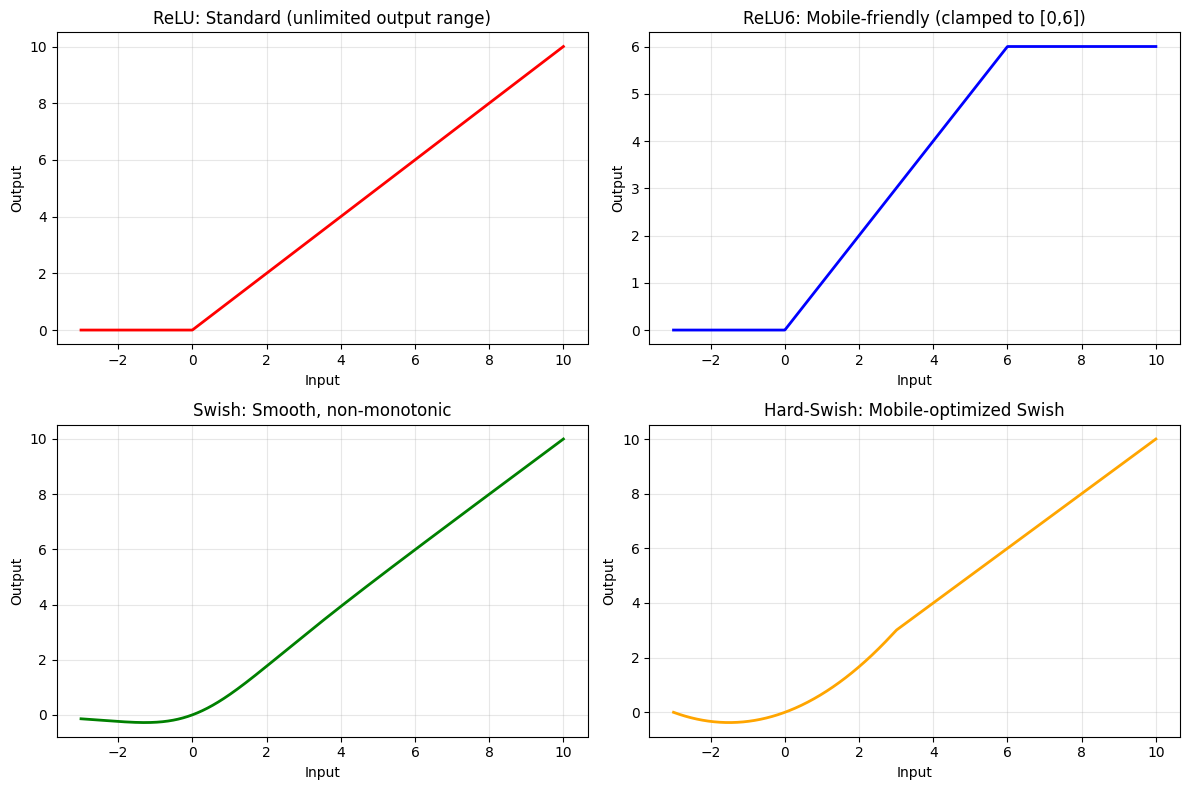

Activation function characteristics:
• ReLU: Unlimited range, potential overflow in quantization
• ReLU6: Bounded [0,6], quantization-friendly, mobile hardware optimized
• Swish: Smooth gradients, but computationally expensive (sigmoid)
• Hard-Swish: Mobile approximation of Swish, piecewise linear


In [13]:
def demonstrate_convolution_efficiency():
    """
    Compare standard vs depthwise separable convolution patterns
    to understand mobile optimization principles
    """
    
    print("=== CONVOLUTION PATTERN COMPARISON ===")
    
    # Standard convolution parameters
    in_channels, out_channels = 128, 256
    kernel_size = 3
    height, width = 56, 56
    
    print(f"Input: {in_channels} channels, {height}x{width} feature map")
    print(f"Output: {out_channels} channels")
    print()
    
    # Standard 3x3 convolution
    std_params = out_channels * in_channels * kernel_size * kernel_size
    std_flops = std_params * height * width
    
    print("STANDARD 3x3 CONVOLUTION:")
    print(f"  Parameters: {std_params:,}")
    print(f"  FLOPs: {std_flops / 1e6:.1f} M")
    print(f"  Memory access pattern: Dense (all input-output channel combinations)")
    print()
    
    # Depthwise separable convolution
    # Depthwise: each input channel gets its own 3x3 filter
    dw_params = in_channels * kernel_size * kernel_size
    dw_flops = dw_params * height * width
    
    # Pointwise: 1x1 convolution to combine channels
    pw_params = in_channels * out_channels * 1 * 1
    pw_flops = pw_params * height * width
    
    total_params = dw_params + pw_params
    total_flops = dw_flops + pw_flops
    
    print("DEPTHWISE SEPARABLE CONVOLUTION:")
    print(f"  Depthwise 3x3: {dw_params:,} params, {dw_flops / 1e6:.1f} M FLOPs")
    print(f"  Pointwise 1x1: {pw_params:,} params, {pw_flops / 1e6:.1f} M FLOPs")
    print(f"  Total: {total_params:,} params, {total_flops / 1e6:.1f} M FLOPs")
    print(f"  Memory access pattern: Sparse (channel-wise then pointwise)")
    print()
    
    # Efficiency comparison
    param_reduction = (std_params - total_params) / std_params * 100
    flop_reduction = (std_flops - total_flops) / std_flops * 100
    
    print("EFFICIENCY GAINS:")
    print(f"  Parameter reduction: {param_reduction:.1f}%")
    print(f"  FLOP reduction: {flop_reduction:.1f}%")
    print(f"  Speedup factor: {std_flops / total_flops:.1f}x")
    
    return {
        'standard': {'params': std_params, 'flops': std_flops},
        'depthwise_sep': {'params': total_params, 'flops': total_flops},
        'param_reduction_pct': param_reduction,
        'flop_reduction_pct': flop_reduction
    }

# Demonstrate efficiency patterns
efficiency_comparison = demonstrate_convolution_efficiency()

print("\n" + "="*60)
print("MOBILE ACTIVATION PATTERNS")
print("="*60)

def compare_activation_functions():
    """Compare activation functions for mobile deployment"""
    
    x = torch.linspace(-3, 10, 1000)
    
    # Standard ReLU
    relu_output = F.relu(x)
    
    # ReLU6 (mobile-friendly, quantization-robust)
    relu6_output = F.relu6(x)
    
    # Swish/SiLU (modern, efficient)
    swish_output = F.silu(x)
    
    # Hard-Swish (mobile-optimized version of Swish)
    def hard_swish(x):
        return x * F.relu6(x + 3) / 6
    
    hard_swish_output = hard_swish(x)
    
    # Plot comparison
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(x, relu_output, label='ReLU', linewidth=2, color='red')
    plt.title('ReLU: Standard (unlimited output range)')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Input')
    plt.ylabel('Output')
    
    plt.subplot(2, 2, 2)
    plt.plot(x, relu6_output, label='ReLU6', linewidth=2, color='blue')
    plt.title('ReLU6: Mobile-friendly (clamped to [0,6])')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Input')
    plt.ylabel('Output')
    
    plt.subplot(2, 2, 3)
    plt.plot(x, swish_output, label='Swish/SiLU', linewidth=2, color='green')
    plt.title('Swish: Smooth, non-monotonic')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Input')
    plt.ylabel('Output')
    
    plt.subplot(2, 2, 4)
    plt.plot(x, hard_swish_output, label='Hard-Swish', linewidth=2, color='orange')
    plt.title('Hard-Swish: Mobile-optimized Swish')
    plt.grid(True, alpha=0.3)
    plt.xlabel('Input')
    plt.ylabel('Output')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'activation_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Activation function characteristics:")
    print("• ReLU: Unlimited range, potential overflow in quantization")
    print("• ReLU6: Bounded [0,6], quantization-friendly, mobile hardware optimized")
    print("• Swish: Smooth gradients, but computationally expensive (sigmoid)")
    print("• Hard-Swish: Mobile approximation of Swish, piecewise linear")

compare_activation_functions()

> **Mobile architecture insight**: 
> 
> Depthwise separable convolutions reduce parameters by ~8x and FLOPs by ~7x compared to standard convolutions by factorizing the spatial and channel-wise filtering operations. This dramatically reduces memory bandwidth requirements - instead of loading large weight tensors, mobile processors can work with smaller depthwise filters and 1x1 pointwise convolutions. 
> 
> Combined with bounded activations like ReLU6, these patterns enable quantization-robust inference on mobile hardware.

## Step 5: Create mobile-friendly architectural blocks

Now let's implement the fundamental building blocks for mobile-efficient architectures. These components form the foundation of modern mobile vision models like MobileNet, EfficientNet, and production mobile applications.

Please note that this is just a subset of possible mobile optimizations which also include squeeze-and-excite blocks, grouped convolutions, etc.

In [9]:
# TODO: Choose mobile-optimized activation function for all layers
# HINT: Options include nn.ReLU(), nn.ReLU6(), nn.Hardswish(), nn.SiLU(), ...
MOBILE_ACTIVATION = nn.ReLU6(inplace=True)  # Add your code here

In [ ]:
class DepthwiseSeparableConv(nn.Module):
    """
    Depthwise Separable Convolution block - the fundamental mobile optimization pattern
    Factorizes standard convolution into depthwise (spatial) + pointwise (channel) operations
    """
    
    
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        
        # TODO: Implement depthwise convolution
        # HINT: Depthwise conv processes each input channel independently
        # Use groups=in_channels to create separate filters for each input channel
        # This reduces parameters from (in_ch × out_ch × k²) to (in_ch × k²)
        # Reference: https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.depthwise = nn.Conv2d(
            in_channels, 
            in_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding,
            groups=in_channels, 
            bias=False 
        )  # Add your code here
        
        # TODO: Implement pointwise convolution  
        # HINT: Pointwise conv is 1x1 convolution that combines depthwise outputs
        # Maps from in_channels to out_channels using 1x1 kernels
        # Reference: https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.pointwise = nn.Conv2d(
            in_channels, 
            out_channels,
            kernel_size=1, 
            stride=1, 
            padding=0, 
            bias=False 
        )  # Add your code here
        
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        # Apply the standard mobile convolution pattern: depthwise → BN → activation → pointwise → BN sequence
        x = self.depthwise(x)
        x = self.bn1(x)
        x = MOBILE_ACTIVATION(x)
        
        x = self.pointwise(x)
        x = self.bn2(x)
        
        return x

class InvertedResidualBlock(nn.Module):
    """
    Inverted Residual Block (MobileNetV2-style) - advanced mobile optimization pattern
    Expands channels → applies depthwise conv → compresses back down
    Inverted compared to ResNet: narrow → wide → narrow instead of wide → narrow → wide
    """
    
    def __init__(self, in_channels, out_channels, stride=1, expand_ratio=6):
        super(InvertedResidualBlock, self).__init__()
        
        self.stride = stride
        self.use_residual = stride == 1 and in_channels == out_channels
        
        hidden_dim = in_channels * expand_ratio
        
        layers = []
        
        # TODO: Implement expansion phase (if needed)
        # HINT: If expand_ratio > 1, add [1x1 conv + batchnorm + activation] to increase channels before depthwise        
        # Example: 64 channels × 6 expand_ratio = 384 expanded channels
        # Reference: https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        
        # Add your code here
        if expand_ratio != 1:
            layers.extend([
                nn.Conv2d(in_channels, hidden_dim, 1, 1, 0, bias=False),  # 1x1 expansion
                nn.BatchNorm2d(hidden_dim),
                MOBILE_ACTIVATION
            ])
        
        # TODO: Add depthwise convolution phase by 
        # HINT: Apply depthwise conv on the expanded channels
        # Use stride for downsampling if needed
        # Reference: https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        depthwise_conv_layer = nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False)  # Add your code here
        layers.extend([
            depthwise_conv_layer,
            nn.BatchNorm2d(hidden_dim),
            MOBILE_ACTIVATION
        ])
        
        # TODO: Add compression phase (pointwise linear)
        # HINT: Compress back to output channels using 1x1 conv
        pointwise_conv_layer = nn.Conv2d(hidden_dim, out_channels, 1, 1, 0, bias=False)  # Add your code here
        layers.extend([
            pointwise_conv_layer,
            nn.BatchNorm2d(out_channels)
            # No activation here - linear bottleneck
        ])
        
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        result = self.conv(x)
        
        # TODO: Add residual connection if applicable
        # HINT: What do you need to return together with the result?
        # Only add residual when input/output shapes match (stride=1, same channels)

        # Add your code here
        if self.use_residual:
            return x + result
       
       return result

> **Mobile building blocks insight**: These architectural patterns form the foundation of all modern mobile vision models (MobileNet, EfficientNet, MobileViT). 
>
> Depthwise separable convolutions reduce memory bandwidth by ~8x by factorizing spatial and channel operations. Inverted residual blocks create an efficient information pathway: compress to narrow bottleneck → expand for rich processing → compress back down. This "narrow-wide-narrow" pattern maximizes representational capacity while minimizing parameter overhead.
>
> The key mobile design principle: **separate spatial processing from channel mixing** to leverage mobile hardware strengths while avoiding bandwidth bottlenecks.

## Step 6: Transform model for mobile hardware

Now assemble these mobile patterns into an optimized CNN architecture. You can follow the guided TODOs to create an efficient mobile-first design.

In [ ]:
class MobileCNN(nn.Module):
    """
    Mobile-optimized CNN that uses depthwise separable convolutions and inverted residuals
    """
    
    def __init__(self, num_classes=10):
        super(MobileCNN, self).__init__()
        
        # TODO: Create initial feature extraction layer
        # HINT: Start with DepthwiseSeparableConv to immediately reduce parameters
        # Use realistic mobile channel counts for practical deployment (not 256+ like servers)
        self.initial_conv = DepthwiseSeparableConv(3, 64, stride=2)  # Add your code here
        # 224x224 → 112x112
        
        # TODO: Add mobile feature extraction blocks
        # HINT: Use InvertedResidualBlock with progressive channel increase
        # Typically channels are doubled with an expand_ratio of 4-6 for good accuracy/efficiency balance
        self.block1 = InvertedResidualBlock(64, 128, stride=2, expand_ratio=4)  # Add your code here
        # 112x112 → 56x56
        
        self.block2 = InvertedResidualBlock(128, 256, stride=2, expand_ratio=4)  # Add your code here
        # 56x56 → 28x28
        
        self.block3 = InvertedResidualBlock(256, 512, stride=2, expand_ratio=4)  # Add your code here
        # 28x28 → 14x14
        
        self.block4 = InvertedResidualBlock(512, 512, stride=1, expand_ratio=4)  # Add your code here
        # 14x14 → 14x14 (feature refinement)
        
        # TODO: Create mobile-optimized classifier
        # HINT: Use global average pooling to eliminate spatial dimensions
        # Keep final linear layer reasonable for mobile deployment
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # Add your code here
        self.classifier = nn.Linear(512, num_classes)  # Add your code here

    def forward(self, x):
        # TODO: Implement forward pass through mobile architecture
        # HINT: The pattern is initial_conv → blocks → global_pool → flatten → classifier
        # What about mobile activations?

        # Add your code here

        x = self.initial_conv(x)
        x = MOBILE_ACTIVATION(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        
        return x

# TODO: Create mobile-optimized model
# HINT: Which device should you typically set it to at initialization, CPU or GPU?
mobile_model = MobileCNN(num_classes=10).to(device)  # Add your code here

print("Mobile-Optimized CNN created:")
print(f"Total parameters: {sum(p.numel() for p in mobile_model.parameters()):,}")
print(f"Model size: {sum(p.numel() * p.element_size() for p in mobile_model.parameters()) / 1024**2:.1f} MB")

# Analyze mobile model efficiency
mobile_stats = analyze_model_efficiency(mobile_model.to("cpu"), "Mobile CNN")

Mobile-Optimized CNN created:
Total parameters: 3,187,563
Model size: 12.2 MB

=== MOBILE CNN EFFICIENCY ANALYSIS ON CPU ===
Parameters: 3,187,563
Model size: 12.2 MB
Estimated activation memory: 49.0 MB
FLOPs: 2.73 G
CPU inference time: 180.1 ms (mobile simulation)
Mobile deployment ready: ✓ Yes


> **Some typical platform-specific architectural considerations:**
>
> - **iOS Neural Engine**: 
>   - **Preferred**: Standard conv sizes (3×3, 1×1), channel counts divisible by 16, ReLU/ReLU6
>   - **Avoid**: Custom activations, dynamic shapes, irregular tensor sizes
>   - **Optimization**: Use Core ML tools, prefer Apple's optimized operation set
>   <br><br>
> - **Android NNAPI/GPU**:
>   - **Preferred**: Depthwise convolutions, ReLU6, quantized operations, parallel-friendly patterns  
>   - **Avoid**: Large kernels (5×5+), complex branching, FP32-only operations
>   - **Optimization**: Design for GPU parallel execution, test across device diversity
>   <br><br>
> - **Qualcomm Hexagon DSP**:
>   - **Preferred**: INT8 quantized operations, fixed-point math, regular memory patterns
>   - **Avoid**: FP32 operations, variable tensor sizes, complex control flow
>   - **Optimization**: Symmetric quantization schemes, Hexagon-specific delegates
>
> _Key insight_: Architecture choices that work well on one platform may underperform on others. Mobile-first design targets the common intersection of efficient patterns across all platforms.

## Step 7: Compare architectures and assess mobile readiness

Let's analyze the architectural transformation results and visualize the efficiency improvements.


ARCHITECTURAL TRANSFORMATION RESULTS
Parameter reduction: 89.7% (30,910,282 → 3,187,563)
Model size reduction: 89.7% (117.9MB → 12.2MB)
FLOP reduction: 86.8% (20.60G → 2.73G)
Speed improvement: 4.0x (719.7ms → 180.1ms)

Mobile deployment readiness:
  Baseline: ✗ Not Ready
  Mobile CNN: ✓ Ready


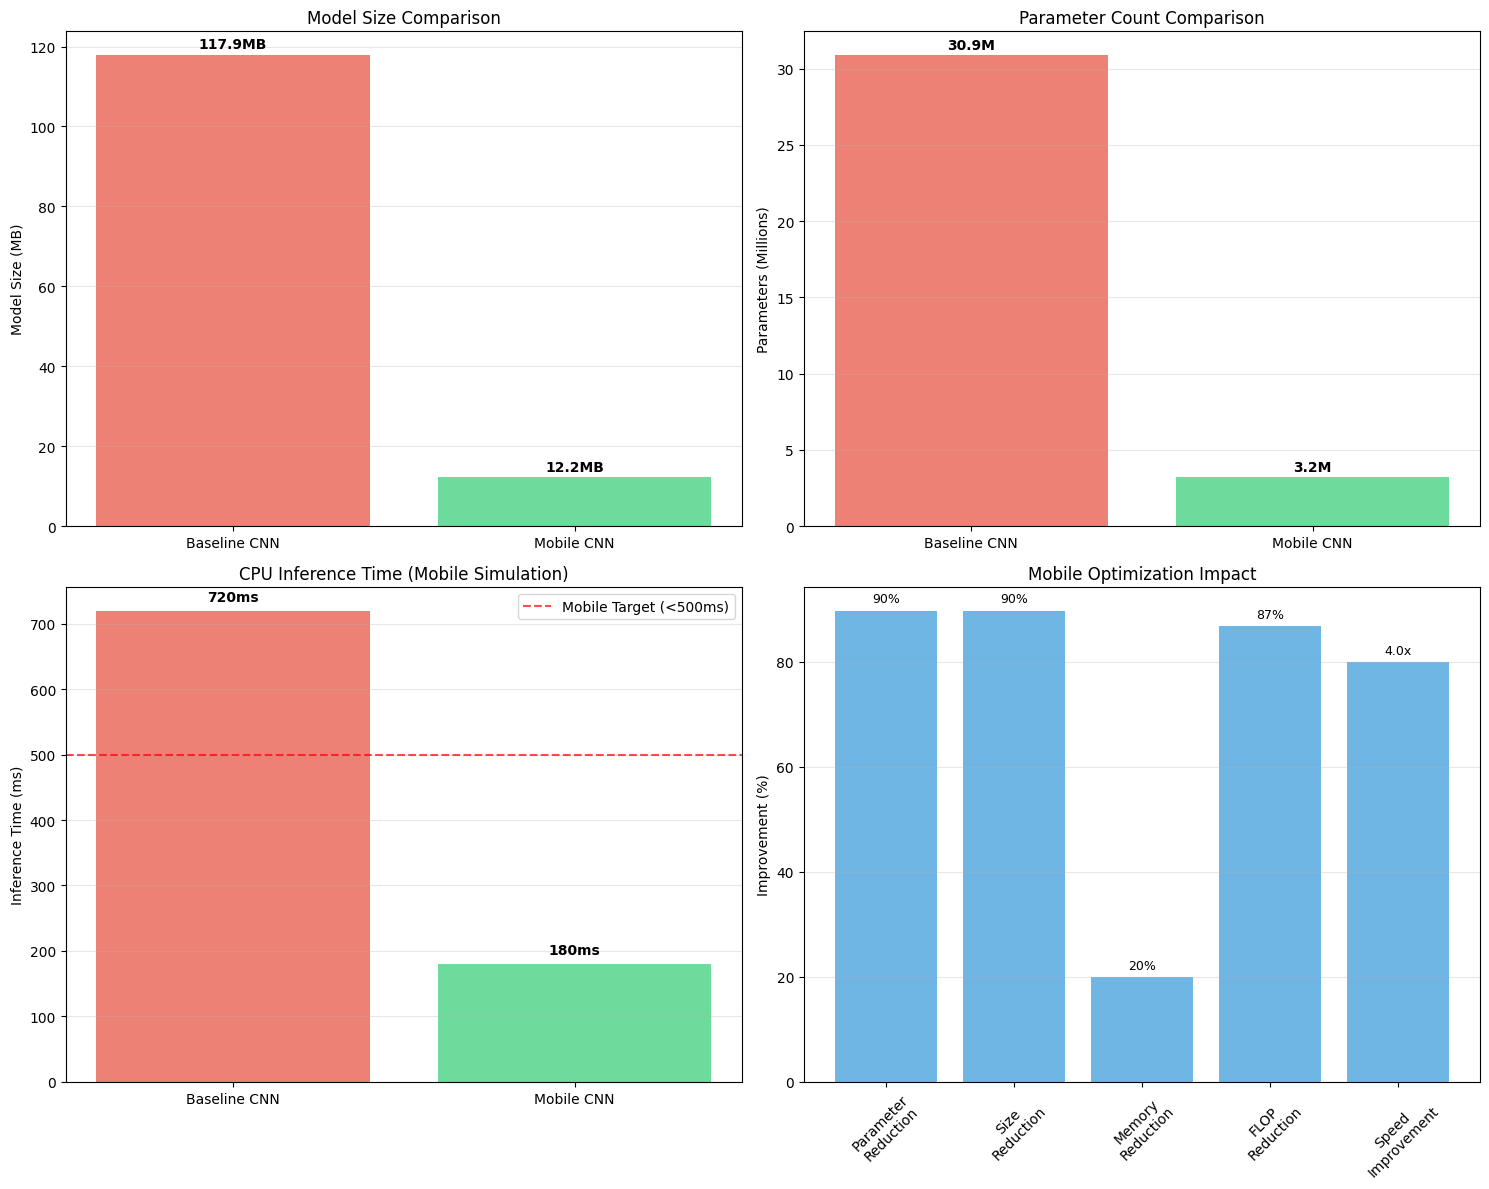


Visualization saved to: assets/exercise3/mobile_optimization_results.png


In [12]:
def create_model_comparison(baseline_stats, mobile_stats, device):
    """Create detailed comparison between baseline and mobile architectures"""
    
    print("\n" + "="*60)
    print("ARCHITECTURAL TRANSFORMATION RESULTS")
    print("="*60)
    
    # Calculate improvement factors
    param_reduction = (baseline_stats['params'] - mobile_stats['params']) / baseline_stats['params'] * 100
    size_reduction = (baseline_stats['size_mb'] - mobile_stats['size_mb']) / baseline_stats['size_mb'] * 100
    memory_reduction = (baseline_stats['memory_mb'] - mobile_stats['memory_mb']) / baseline_stats['memory_mb'] * 100 if baseline_stats['memory_mb'] > 0 else 0
    flop_reduction = (baseline_stats['flops_g'] - mobile_stats['flops_g']) / baseline_stats['flops_g'] * 100
    speed_improvement = baseline_stats['cpu_time_ms'] / mobile_stats['cpu_time_ms']
    
    print(f"Parameter reduction: {param_reduction:.1f}% ({baseline_stats['params']:,} → {mobile_stats['params']:,})")
    print(f"Model size reduction: {size_reduction:.1f}% ({baseline_stats['size_mb']:.1f}MB → {mobile_stats['size_mb']:.1f}MB)")
    if device=="cuda":
        print(f"Memory reduction: {memory_reduction:.1f}% ({baseline_stats['memory_mb']:.1f}MB → {mobile_stats['memory_mb']:.1f}MB)")
    print(f"FLOP reduction: {flop_reduction:.1f}% ({baseline_stats['flops_g']:.2f}G → {mobile_stats['flops_g']:.2f}G)")
    print(f"Speed improvement: {speed_improvement:.1f}x ({baseline_stats['cpu_time_ms']:.1f}ms → {mobile_stats['cpu_time_ms']:.1f}ms)")
    
    print(f"\nMobile deployment readiness:")
    print(f"  Baseline: {'✓ Ready' if baseline_stats['mobile_ready'] else '✗ Not Ready'}")
    print(f"  Mobile CNN: {'✓ Ready' if mobile_stats['mobile_ready'] else '✗ Not Ready'}")
    
    return {
        'param_reduction_pct': param_reduction,
        'size_reduction_pct': size_reduction,
        'memory_reduction_pct': memory_reduction,
        'flop_reduction_pct': flop_reduction,
        'speed_improvement': speed_improvement
    }

def plot_results(baseline, mobile, stats, output_dir):
    """Create visualization of comparison results."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    models = ['Baseline CNN', 'Mobile CNN']
    colors = ['#e74c3c', '#2ecc71']

    def _add_bar_labels(ax, bars, values, fmt="{:.1f}", offset=1, bold=True):
        """Helper to add labels on top of bars."""
        for bar, val in zip(bars, values):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + offset,
                fmt.format(val),
                ha='center', va='bottom',
                fontweight='bold' if bold else 'normal'
            )

    # 1. Model Size
    sizes = [baseline['size_mb'], mobile['size_mb']]
    bars = ax1.bar(models, sizes, color=colors, alpha=0.7)
    ax1.set_ylabel('Model Size (MB)')
    ax1.set_title('Model Size Comparison')
    ax1.grid(axis='y', alpha=0.3)
    _add_bar_labels(ax1, bars, sizes, fmt="{:.1f}MB")

    # 2. Parameter Count
    params = [baseline['params'] / 1e6, mobile['params'] / 1e6]
    bars = ax2.bar(models, params, color=colors, alpha=0.7)
    ax2.set_ylabel('Parameters (Millions)')
    ax2.set_title('Parameter Count Comparison')
    ax2.grid(axis='y', alpha=0.3)
    _add_bar_labels(ax2, bars, params, fmt="{:.1f}M", offset=0.2)

    # 3. Inference Time
    times = [baseline['cpu_time_ms'], mobile['cpu_time_ms']]
    bars = ax3.bar(models, times, color=colors, alpha=0.7)
    ax3.set_ylabel('Inference Time (ms)')
    ax3.set_title('CPU Inference Time (Mobile Simulation)')
    ax3.axhline(y=500, color='red', linestyle='--', alpha=0.7, label='Mobile Target (<500ms)')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    _add_bar_labels(ax3, bars, times, fmt="{:.0f}ms", offset=10)

    # 4. Optimization Impact
    categories = [
        'Parameter\nReduction', 'Size\nReduction',
        'Memory\nReduction', 'FLOP\nReduction', 'Speed\nImprovement'
    ]
    values = [
        stats['param_reduction_pct'],
        stats['size_reduction_pct'],
        stats['memory_reduction_pct'],
        stats['flop_reduction_pct'],
        stats['speed_improvement'] * 20  # scaled
    ]
    bars = ax4.bar(categories, values, color='#3498db', alpha=0.7)
    ax4.set_ylabel('Improvement (%)')
    ax4.set_title('Mobile Optimization Impact')
    ax4.tick_params(axis='x', rotation=45)
    ax4.grid(axis='y', alpha=0.3)

    # Add values (handle speed separately)
    for bar, cat, val in zip(bars, categories, values):
        if cat == 'Speed\nImprovement':
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                     f"{stats['speed_improvement']:.1f}x",
                     ha='center', va='bottom', fontsize=9)
        else:
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                     f"{val:.0f}%", ha='center', va='bottom', fontsize=9)

    # Plot and save
    plt.tight_layout()
    out_path = os.path.join(output_dir, 'mobile_optimization_results.png')
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\nVisualization saved to: {out_path}")

# Get comparison results
comparison_results = create_model_comparison(baseline_stats, mobile_stats, device="cpu")
plot_results(baseline_stats, mobile_stats, comparison_results, output_dir)

> **TODO: Analyze metric-by-metric transformation results**: Through systematic application of mobile-first design patterns, you should see dramatic efficiency improvements while maintaining the model's core functionality. 
> 
> Examine your architectural transformation results and identify patterns:
> 
> **1\.** Which efficiency improvement surprised you most and why?
>   
> _Your answer:_ The memory reduction was only 20% despite 90% parameter reduction. I assumed they'd be more closely related.
> 
> **2\.** Compare the magnitude of different improvements:
>   - Which metrics showed the largest reductions/improvements?
>   - Do the relative improvements match your expectations?
>   - What might explain the relationship between parameter reduction and memory reduction?
> 
> _Your analysis:_ Parameters, model size, and FLOPs all dropped ~90%, which makes sense since they're all related to the number of weights. The 20% memory reduction is smaller but reasonable since activation memory depends on input size and network depth, not just parameter count.
> 
> **3\.** What's the difference between "model size" and "runtime memory" during mobile inference?
> 
> *Hint: Consider what happens when your model processes an image...*
> 
> _Your explanation:_ Model size is just the stored weights/parameters. Runtime memory includes the model weights PLUS all the activation tensors (intermediate layer outputs) created during forward pass. Even with fewer parameters, we still need memory to store feature maps at each layer, which depends on input size and network depth, not parameter count.
> 
> **4\.** Why might reducing model parameters not always solve mobile memory constraints?
> 
> _Your reasoning:_ Because activation memory can dominate total memory usage. A 3MB model might still need 50MB of runtime memory for activations. So you need to optimize both parameter count AND activation memory patterns (through techniques like depthwise convs, bottlenecks, global pooling) to truly enable mobile deployment.
> 
> _**IMPORTANT: Missing accuracy retention metric!**_ This exercise focused on architectural efficiency but didn't measure accuracy. In real mobile deployment, you must validate that optimization doesn't break model performance by finding architectures that maximize both efficiency and accuracy simultaneously. Why not take accuracy validation as a bonus challenge?

## Conclusion

In this exercise, you have transformed a standard CNN into a mobile-optimized architecture using systematic hardware-aware design patterns, then analyzed the efficiency trade-offs that determine real-world deployment success.

Key architectural principles demonstrated include:

- _**Hardware-software co-design**_: Architecture choices directly determine mobile deployment viability - post-hoc optimization alone cannot bridge fundamental design gaps

- _**Multi-dimensional efficiency**_: Mobile optimization requires balancing parameters, memory, computation, and accuracy simultaneously, not just minimizing one metric

- _**Platform-aware patterns**_: Depthwise separable convolutions, inverted residuals, and bounded activations align with mobile hardware strengths while avoiding bandwidth bottlenecks

These design principles enable real-time visual AI experiences while respecting the power, memory, and computational limits of mobile devices.

Through your analysis, you've uncovered why mobile deployment requires understanding the relationship between model architecture and runtime constraints. The efficiency patterns you observed——and any surprises in the metric comparisons——reflect fundamental hardware realities that shape production mobile AI systems.

##### **Next mobile architecture challenges to explore:**

- **Batch size optimization**: Compare mobile architecture performance with different batch sizes for deployment scenarios

- **Dynamic inference**: Implement early-exit architectures for variable computational budgets

- **Multi-resolution deployment**: Design single architectures that adapt to different input sizes based on device capabilities  

- **Hardware-specific tuning**: Optimize channel counts and expand ratios for iOS Neural Engine vs Android NNAPI

- **Advanced mobile patterns**: Implement squeeze-and-excitation blocks, neural architecture search for mobile constraints

- **Memory-bandwidth co-design**: Optimize activation memory patterns for mobile memory hierarchies